In [57]:
import numpy as np
import math
import scipy.linalg as la
import matplotlib.pyplot as plt
import scipy
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib widget


In [37]:
def plot3D(Y, Xgrid, tgrid):
     T, X = np.meshgrid(np.transpose(tgrid), Xgrid)

     # Create a 3D plot
     fig = plt.figure(figsize=(10, 10))  # You can adjust the size as needed
     ax = fig.add_subplot(111, projection='3d')
     ax.plot_surface(T, X, np.transpose(Y))

     ax.set_xlabel('Time')
     ax.set_ylabel('Space')
     ax.set_zlabel('Value')

     plt.show()

In [86]:
def pulse(x):
    return 3*np.exp(-100*(x-0.5)**2)


\begin{gather*}
u_{t}+uu_{x}=d\cdot u_{xx}\\
u(t+\Delta t,x)\approx u(t,x)+\Delta tu_{t}+\frac{\Delta t^{2}}{2!}u_{tt}\\
\text{Invicid Borgir equation: }u_{t}=-uu_{x}\\
u_{tt}=-u_{t}u_{x}-uu_{xt}\\
u_{tx}=-u_{x}^{2}-uu_{xx}\\
u_{tt}=-uu_{x}^{2}-u(-u_{x}^{2}-uu_{xx})\\
u_{tt}=u^{2}u_{xx}\\
u(t+\Delta t,x)\approx u-\Delta tuu_{x}+\frac{\Delta t^{2}}{2!}u^{2}u_{xx}\\
\text{Using a symetric finite difference for derivitive approximation}\\
u_{j}^{n+1}=u_{j}^{n}-\Delta tu_{j}^{n}\frac{u_{j+1}^{n}-u_{j-1}^{n}}{2\Delta x}+\frac{\Delta t^{2}}{2!}\left(u_{j}^{n}\right)^{2}\frac{u_{j+1}^{n}-2u_{j}^{n}+u_{j-1}^{n}}{\Delta x^{2}}\\
\left\{ \mu=\frac{\Delta t}{\Delta x}\right\} \\
u_{j}^{n+1}=u_{j}^{n}-\frac{\mu}{2}u_{j}^{n}\left(u_{j+1}^{n}-u_{j-1}^{n}\right)+\frac{\mu^{2}}{2}\left(u_{j}^{n}\right)^{2}\left(u_{j+1}^{n}-2u_{j}^{n}+u_{j-1}^{n}\right)
\end{gather*}

In [49]:
def LWsolver(g0, N, M, d):
    deltaX = 1/N  # rumssteg från x0 till xN-1
    dt = 1/M  # tidsteg från t0 till tN
    Xgrid = np.linspace(0, 1, N+1)
    tgrid = np.linspace(0, 1, M+1)

    T = la.toeplitz([-2, 1] + [0] * (N-1)) ##Skapar en Toeplitz matris för disc av andraderivatan spatiallt  
    T[-1,0] = 1
    T[0,-1] = 1
    T = T/deltaX**2
    
    Xop = d*T*dt/2 
    op = np.linalg.inv(np.eye(N+1)-Xop)@(np.eye(N+1)+Xop)  

    Y = np.zeros((M+1, N+1)) #Första värdet är tidssteget, andra är x-steget.
    Y[0,:] = g0 #Sätter initialvärden
    u = np.zeros_like(Y)
    u[0,:] = g0
    LW = np.zeros(N+1)

    for n in range(M):
        Y[n+1,:] = op@np.transpose(Y[n, :])
        for j in range(N+1):
            if j == N:
                LW[j] = u[n,j] + (dt*u[n,j]*(u[n,0]-u[n,j-1])/(2*deltaX)) - (dt**2/(2*deltaX**2))*(u[n,0]-2*u[n,j]+u[n,j-1])*u[n,j]**2
            else:
                LW[j] = u[n,j] + (dt*u[n,j]*(u[n,j+1]-u[n,j-1])/(2*deltaX)) - (dt**2/(2*deltaX**2))*(u[n,j+1]-2*u[n,j]+u[n,j-1])*u[n,j]**2 #ingen matris
        u[n+1,:] = np.linalg.inv(np.eye(N+1)-Xop)@np.transpose(LW) + Y[n+1,:]
        #Y[i+1,-1] = Y[i+1,0]
    return Y, Xgrid, tgrid

In [55]:
def LW(U, dt, dx):
    unew = np.zeros_like(U)
    N = len(U)
    for n in range(N):
        S = (U[n-1]-U[(n+1)%N])/(dx*2)   # Modulus för när vi går out-of-bounds 
        T = (U[n-1]-2*U[n]-U[(n+1)%N])/(dx**2)
           
        unew[n] = U[n] + dt*U[n]*S + ((dt)**2)/2*(U[n]**2)*T  
    
    return unew 

In [87]:
def LWsolver2(g0, N, M, d):
    deltaX = 1/N  # rumssteg från x0 till xN-1
    dt = 1/M  # tidsteg från t0 till tN
    Xgrid = np.linspace(0, 1, N+1)
    tgrid = np.linspace(0, 1, M)
    T = la.toeplitz([-2, 1] + [0] * (N-1)) ##Skapar en Toeplitz matris för disc av andraderivatan spatiallt  
    T[-1,0] = 1
    T[0,-1] = 1
    T = T/deltaX**2
    U = np.zeros((M,N+1))

    U[0,:] = g0
    for i in range(M-1):
        U[i+1,:] = np.linalg.inv(np.eye(N+1) - dt/2 * d * T)@(np.transpose(LW(U[i,:],dt,deltaX)) + dt/2 * d * T@np.transpose(U[i,:]))

    #print(U)
    return U, Xgrid, tgrid
                

    


    




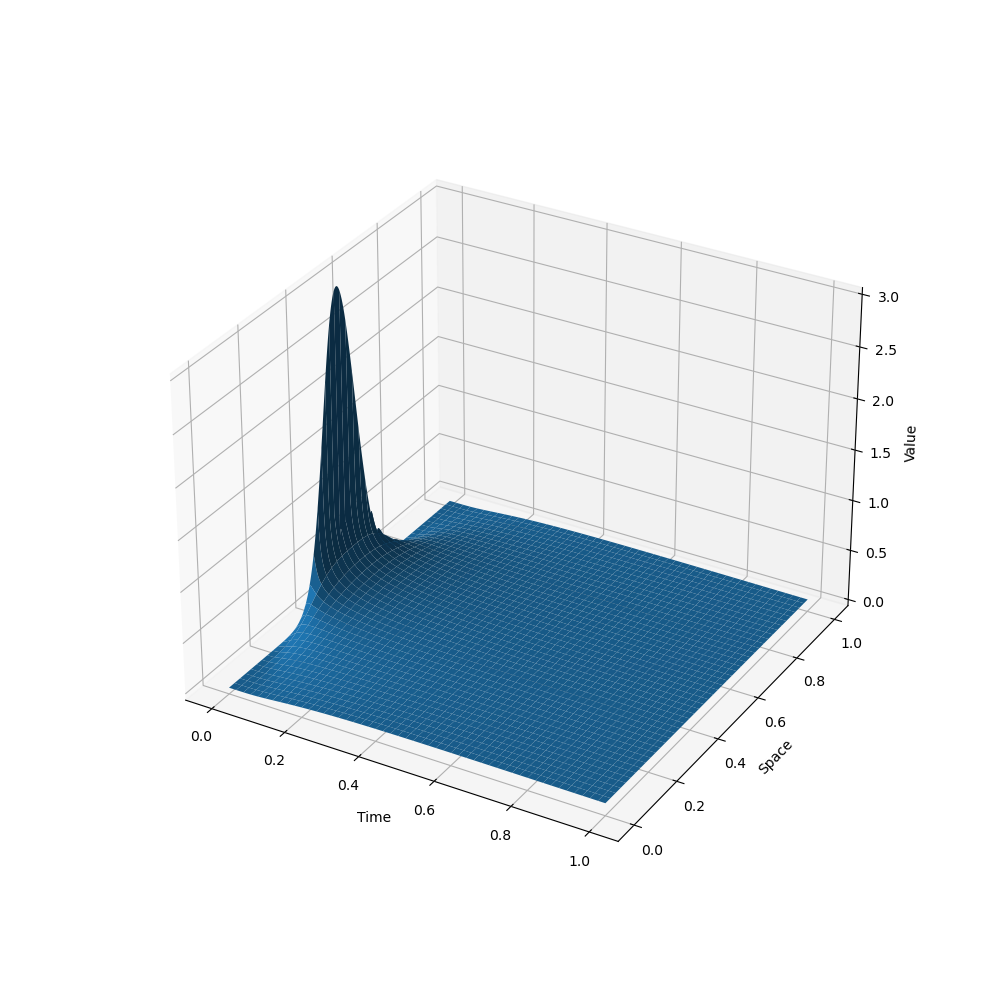

C:\Users\cross\AppData\Local\Temp\ipykernel_22916\3773900379.py:27: RuntimeWarning: overflow encountered in double_scalars
  LW[j] = u[n,j] + (dt*u[n,j]*(u[n,j+1]-u[n,j-1])/(2*deltaX)) - (dt**2/(2*deltaX**2))*(u[n,j+1]-2*u[n,j]+u[n,j-1])*u[n,j]**2 #ingen matris
C:\Users\cross\AppData\Local\Temp\ipykernel_22916\3773900379.py:28: RuntimeWarning: invalid value encountered in matmul
  u[n+1,:] = np.linalg.inv(np.eye(N+1)-Xop)@np.transpose(LW) + Y[n+1,:]


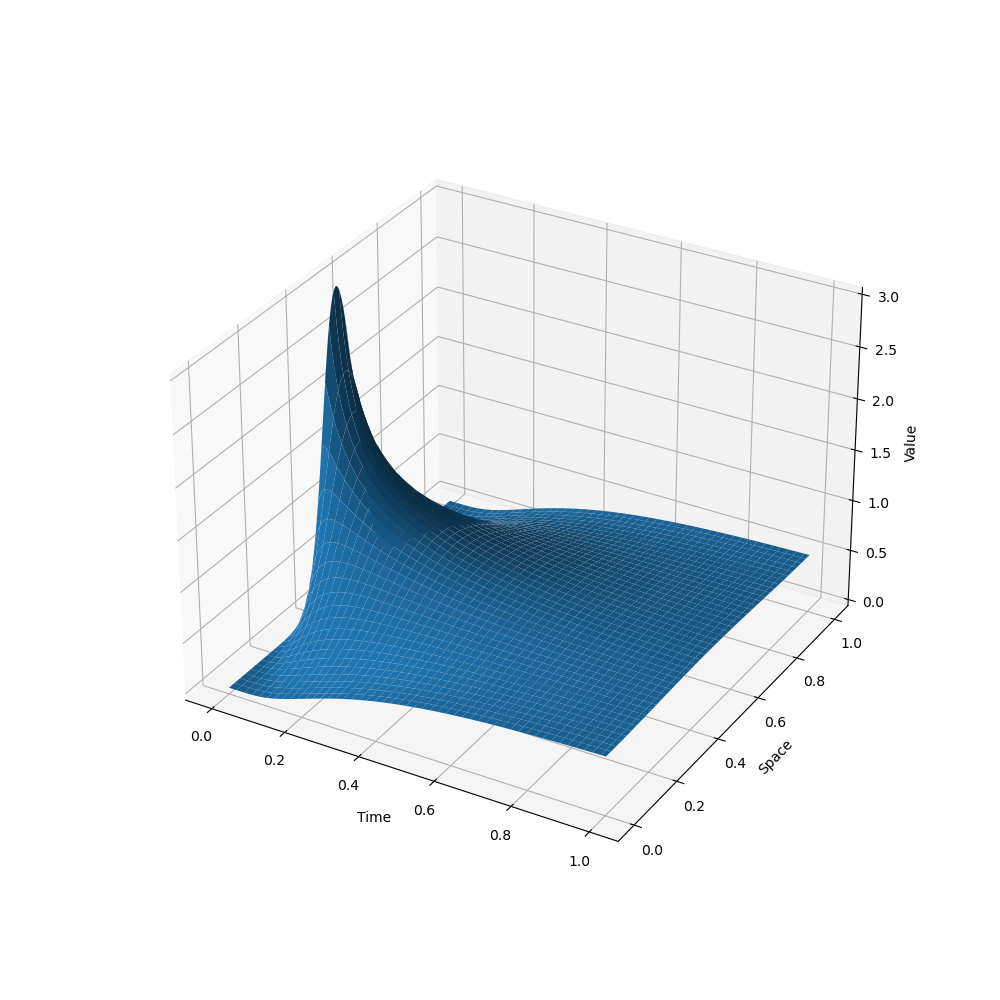

In [89]:
d = 0.1
N, M = 300, 1000

g0 = pulse(np.linspace(0, 1, N+1))

Y, Xgrid, tgrid = LWsolver2(g0, N, M, d)
plot3D(Y, Xgrid, tgrid)
Y, Xgrid, tgrid = LWsolver(g0, N, M, d)
plot3D(Y, Xgrid, tgrid)
